In [19]:
from __future__ import print_function, division

from os.path import basename, exists

%matplotlib inline




def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")


Downloaded thinkstats2.py
Downloaded thinkplot.py
Downloaded mj-clean.csv


# Week 9

Joshua Burden  
DSC530 Week 9
Bellevue University  
Catherine Williams  
08/07/2022

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT7

In [20]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [21]:
transactions = pd.read_csv("mj-clean.csv", on_bad_lines='skip', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


# Exercise: 
The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of RunLinearModel that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [22]:
# Creating a function to groups transactions by day and compute the daily mean into a dataframe.
def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [23]:
# Creating a  function to return a map from quality name to a DataFrame of the daily averages.
def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

dailies = GroupByQualityAndDay(transactions)

In [24]:
# Running a linear model with quadratic term of prices versus years.
def RunQuadraticModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [25]:
# Summary of linear model with quadratic term
name = 'high'
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 07 Aug 2022   Prob (F-statistic):          4.57e-164
Time:                        15:57:57   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Function for plotting the data to fitted values
def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')

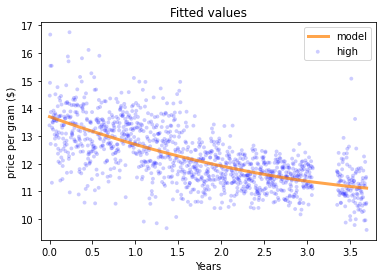

In [27]:
# Plotting of our fitted vaules and actuals
PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted values',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='price per gram ($)')

In [28]:
# Function to resample from the residuals.
def SimulateResults(daily, iters=101, func=RunQuadraticModel):
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [29]:
# Function to Generate Predictions using our model.
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [30]:
# Function to help us plot our predictions.
def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadraticModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

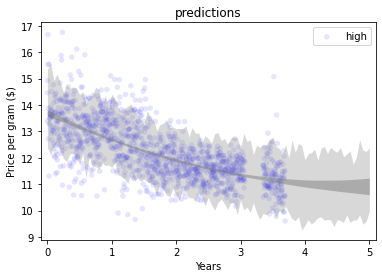

In [31]:
# Plotting our predictions using the above functions.
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title='predictions',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='Price per gram ($)')

# Exercise: 

Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [35]:
# Function to compute a serial correlation with the given lag.
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [36]:
# Creating a function using "statsmodels" to run a linear model of price as a function of time.
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results 

In [37]:
# Creating functing to test serial correlations by computing the test statistic and running a model of the null hypothesis.
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [38]:
# Running a correlation between consecutive prices
name = 'high'
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Test Correlation:", test.actual," Test P-Value:", pvalue)

Test Correlation: 0.4852293761947381  Test P-Value: 0.0


In [39]:
# Running a serial correlation of the residuals of the linear model
_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Linear Correlation:", test.actual, " Linear P-Value:", pvalue)

Linear Correlation: 0.07570473767506261  Linear P-Value: 0.006


In [40]:
# Running a serial correlation of the residuals of the quadratic model
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Quadractic Correlation:", test.actual, " Quadractic P-Value:", pvalue)

Quadractic Correlation: 0.05607308161289916  Quadractic P-Value: 0.045


In [41]:

class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag
# Solution

# test the correlation between consecutive prices

name = "high"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947381 0.0


In [43]:
# Solution

# test for serial correlation in residuals of the linear model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

# Solution

# test for serial correlation in residuals of the quadratic model

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506261 0.013
0.05607308161289916 0.059


In [45]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pd.Series(reindexed.ppg).ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed["ewma"] = ewma
    reindexed["resid"] = reindexed.ppg - ewma
    return reindexed

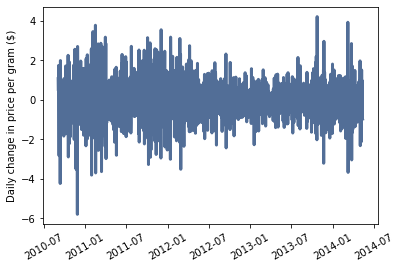

In [51]:
import matplotlib.pyplot as plt
name = "high"
daily = dailies[name]

filled = FillMissing(daily)
diffs = filled.ppg.diff()

thinkplot.plot(diffs)
plt.xticks(rotation=30)
thinkplot.Config(ylabel="Daily change in price per gram ($)")

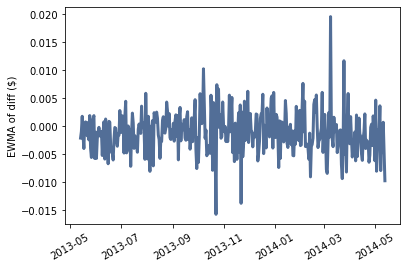

In [52]:
filled["slope"] = diffs.ewm(span=365).mean()
thinkplot.plot(filled.slope[-365:])
plt.xticks(rotation=30)
thinkplot.Config(ylabel="EWMA of diff ($)")

In [53]:
# extract the last inter and the mean of the last 30 slopes
start = filled.index[-1]
inter = filled.ewma[-1]
slope = filled.slope[-30:].mean()

start, inter, slope

(Timestamp('2014-05-13 00:00:00', freq='D'),
 10.929518765455489,
 -0.002619825851504032)

In [54]:
# reindex the DataFrame, adding a year to the end
dates = pd.date_range(filled.index.min(), filled.index.max() + np.timedelta64(365, "D"))
predicted = filled.reindex(dates)

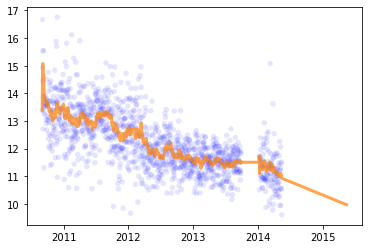

In [55]:
# generate predicted values and add them to the end
predicted["date"] = predicted.index
one_day = np.timedelta64(1, "D")
predicted["days"] = (predicted.date - start) / one_day
predict = inter + slope * predicted.days
predicted.ewma.fillna(predict, inplace=True)
# plot the actual values and predictions
thinkplot.Scatter(daily.ppg, alpha=0.1, label=name)
thinkplot.Plot(predicted.ewma, color="#ff7f00")